In [1]:
##Imports and alasiases

import numpy as np
import pandas as pd
import xlsxwriter

# plotting imports
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import dataframe_image as dfi

#content based recommendor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize    
nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet as wn
import string

#data and modleing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from surprise import Reader, Dataset, KNNBasic, NormalPredictor,BaselineOnly,KNNWithMeans,KNNBaseline
from surprise import SVD, SVDpp, NMF, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import accuracy


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Keega\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#get coffee data

#Read in the file
coffeeRaw = pd.read_csv('C:/Users/Keega/Desktop/School/DS 784 CapStone/RawFiles/coffee-data/saved_data/enriched_list_all.csv')

#basic exploration
coffeeRaw.head()
summary = coffeeRaw.describe()
summary = summary.transpose()

##print(summary)
summary.to_excel("dataSummary.xlsx")
summary

,count,mean,std,min,25%,50%,75%,max
score,335.0,88.179403,1.865177,82.6,86.80,87.5,89.45,93.1
weight,1.0,6.000000,NaN,6.0,6.00,6.0,6.00,6.0
flavor_floral,337.0,0.378338,0.825580,0.0,0.00,0.0,0.00,4.0
flavor_honey,337.0,0.658754,1.045479,0.0,0.00,0.0,1.50,3.5
flavor_sugars,337.0,3.123145,0.555383,1.0,3.00,3.0,3.50,4.0
flavor_caramel,337.0,1.436202,1.217284,0.0,0.00,2.0,2.50,4.0
flavor_fruits,337.0,1.790801,1.089727,0.0,1.00,2.0,2.50,4.0
flavor_citrus,337.0,0.908012,1.073419,0.0,0.00,0.0,2.00,3.5
flavor_berry,337.0,1.100890,1.182801,0.0,0.00,1.0,2.00,4.0
flavor_cocoa,337.0,3.120178,1.301193,0.0,3.00,3.5,4.00,5.0


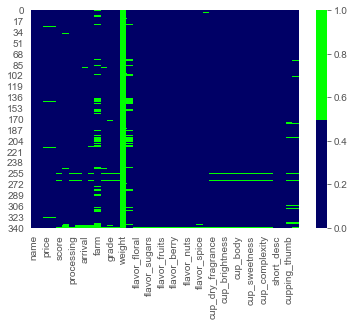

In [3]:
#find Nulls
nullColors = ['#000066','#00ff00']
sns.heatmap(coffeeRaw.isnull(), cmap=sns.color_palette(nullColors))


In [4]:
#weight nulls need changed to 1 or 1lbs. 

coffeeFiltered = coffeeRaw.drop(['weight'], axis=1)
#drop url cols product_url, product_img, cupping_thumb, flavor_thumb
coffeeFiltered = coffeeFiltered.drop(['product_url','product_img','cupping_thumb','flavor_thumb'], axis=1)

#drop roes with no score
coffeeFiltered = coffeeFiltered.dropna(subset=['score'])

#drop coffee sets (may not be needed)
dropVals = ['Set']
coffeeFiltered =  coffeeFiltered[~coffeeFiltered['name'].str.contains('|'.join(dropVals))]

## handel NAN regions
print(coffeeFiltered.columns)
coffeeFiltered.head()
summaryFiltered = coffeeFiltered.describe()
summaryFiltered.transpose()


Index(['name', 'price', 'availability', 'score', 'region', 'processing',
       'drying', 'arrival', 'packaging', 'farm', 'cultivar', 'grade', 'roast',
       'type', 'flavor_floral', 'flavor_honey', 'flavor_sugars',
       'flavor_caramel', 'flavor_fruits', 'flavor_citrus', 'flavor_berry',
       'flavor_cocoa', 'flavor_nuts', 'flavor_rustic', 'flavor_spice',
       'flavor_body', 'cup_dry_fragrance', 'cup_wet_aroma', 'cup_brightness',
       'cup_flavor', 'cup_body', 'cup_finish', 'cup_sweetness',
       'cup_clean_cup', 'cup_complexity', 'cup_uniformity', 'short_desc'],
      dtype='object')


,count,mean,std,min,25%,50%,75%,max
score,335.0,88.179403,1.865177,82.6,86.80,87.5,89.45,93.1
flavor_floral,335.0,0.374627,0.823012,0.0,0.00,0.0,0.00,4.0
flavor_honey,335.0,0.662687,1.047357,0.0,0.00,0.0,1.50,3.5
flavor_sugars,335.0,3.117910,0.552871,1.0,3.00,3.0,3.50,4.0
flavor_caramel,335.0,1.429851,1.217514,0.0,0.00,2.0,2.50,4.0
flavor_fruits,335.0,1.783582,1.086195,0.0,1.00,2.0,2.50,4.0
flavor_citrus,335.0,0.901493,1.073286,0.0,0.00,0.0,2.00,3.5
flavor_berry,335.0,1.092537,1.180723,0.0,0.00,1.0,2.00,4.0
flavor_cocoa,335.0,3.117910,1.304750,0.0,3.00,3.5,4.00,5.0
flavor_nuts,335.0,0.673134,0.938144,0.0,0.00,0.0,1.50,3.0


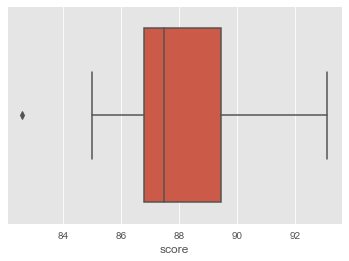

In [5]:
#split data sets for score, flavor and cupping

#score
sns.boxplot(x=coffeeFiltered["score"],orient="h")


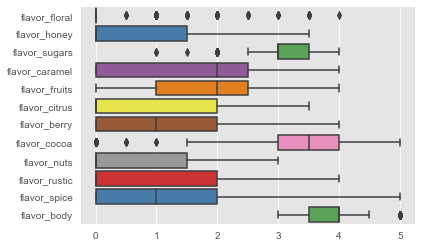

In [6]:
#set lavor cols
flavorCols = ['flavor_floral','flavor_honey','flavor_sugars','flavor_caramel','flavor_fruits','flavor_citrus','flavor_berry','flavor_cocoa','flavor_nuts','flavor_rustic','flavor_spice','flavor_body']

#make df and box plot of flavor cols
flavorDf =  coffeeFiltered[flavorCols]
sns.boxplot(data=flavorDf,orient="h", palette="Set1")

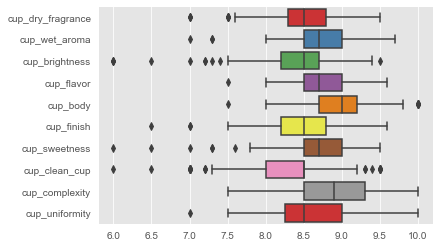

In [7]:
#set cupping cols
cuppingCols = ["cup_dry_fragrance","cup_wet_aroma","cup_brightness","cup_flavor","cup_body","cup_finish","cup_sweetness","cup_clean_cup","cup_complexity","cup_uniformity"]

#make df and box plot of cupping cols
cuppingDf =  coffeeFiltered[cuppingCols]
sns.boxplot(data=cuppingDf,orient="h", palette="Set1")

In [8]:
#corralation overall
coffeeCorr = coffeeFiltered.corr()
cofcorr = coffeeCorr.style.background_gradient(cmap='seismic').set_precision(2)

#export for paper 
dfi.export(cofcorr, 'cofcorr.png')
cofcorr

,score,flavor_floral,flavor_honey,flavor_sugars,flavor_caramel,flavor_fruits,flavor_citrus,flavor_berry,flavor_cocoa,flavor_nuts,flavor_rustic,flavor_spice,flavor_body,cup_dry_fragrance,cup_wet_aroma,cup_brightness,cup_flavor,cup_body,cup_finish,cup_sweetness,cup_clean_cup,cup_complexity,cup_uniformity
score,1,0.64,0.21,0.38,-0.54,0.71,0.69,0.55,-0.65,-0.6,-0.24,0.44,-0.19,0.82,0.87,0.69,0.93,-0.15,0.8,0.69,0.55,0.66,0.18
flavor_floral,0.64,1,0.31,0.17,-0.38,0.36,0.38,0.16,-0.49,-0.32,-0.16,0.15,-0.21,0.53,0.59,0.35,0.62,-0.19,0.54,0.39,0.35,0.4,0.13
flavor_honey,0.21,0.31,1,0.083,-0.11,0.11,0.19,-0.088,-0.24,-0.17,-0.23,0.056,-0.13,0.27,0.28,0.25,0.24,-0.13,0.26,0.28,0.22,0.12,0.039
flavor_sugars,0.38,0.17,0.083,1,-0.21,0.32,0.29,0.19,-0.29,-0.42,-0.21,0.23,-0.15,0.49,0.48,0.47,0.43,-0.15,0.41,0.59,0.35,0.26,-0.082
flavor_caramel,-0.54,-0.38,-0.11,-0.21,1,-0.55,-0.37,-0.42,0.41,0.4,-0.13,-0.28,0.1,-0.43,-0.46,-0.28,-0.48,0.071,-0.32,-0.3,-0.12,-0.5,-0.057
flavor_fruits,0.71,0.36,0.11,0.32,-0.55,1,0.52,0.78,-0.41,-0.61,0.11,0.32,-0.015,0.64,0.64,0.52,0.73,-0.012,0.51,0.55,0.17,0.72,-0.05
flavor_citrus,0.69,0.38,0.19,0.29,-0.37,0.52,1,0.32,-0.62,-0.5,-0.26,0.45,-0.29,0.63,0.66,0.65,0.67,-0.3,0.62,0.49,0.48,0.46,0.18
flavor_berry,0.55,0.16,-0.088,0.19,-0.42,0.78,0.32,1,-0.18,-0.43,0.18,0.23,0.17,0.46,0.46,0.32,0.55,0.19,0.35,0.39,0.05,0.57,-0.13
flavor_cocoa,-0.65,-0.49,-0.24,-0.29,0.41,-0.41,-0.62,-0.18,1,0.42,0.34,-0.32,0.54,-0.66,-0.68,-0.63,-0.62,0.55,-0.6,-0.49,-0.52,-0.34,-0.38
flavor_nuts,-0.6,-0.32,-0.17,-0.42,0.4,-0.61,-0.5,-0.43,0.42,1,0.014,-0.46,0.13,-0.58,-0.58,-0.54,-0.61,0.11,-0.45,-0.56,-0.24,-0.61,-0.075


In [9]:
#corralation in flavor
flavorCorr = flavorDf.corr()
flcorr = flavorCorr.style.background_gradient(cmap='seismic').set_precision(2)

#export for paper 
dfi.export(flcorr, 'flavorCorr.png')
flcorr

,flavor_floral,flavor_honey,flavor_sugars,flavor_caramel,flavor_fruits,flavor_citrus,flavor_berry,flavor_cocoa,flavor_nuts,flavor_rustic,flavor_spice,flavor_body
flavor_floral,1,0.31,0.17,-0.38,0.36,0.38,0.16,-0.49,-0.32,-0.16,0.15,-0.21
flavor_honey,0.31,1,0.083,-0.11,0.11,0.19,-0.088,-0.24,-0.17,-0.23,0.056,-0.13
flavor_sugars,0.17,0.083,1,-0.21,0.32,0.29,0.19,-0.29,-0.42,-0.21,0.23,-0.15
flavor_caramel,-0.38,-0.11,-0.21,1,-0.55,-0.37,-0.42,0.41,0.4,-0.13,-0.28,0.1
flavor_fruits,0.36,0.11,0.32,-0.55,1,0.52,0.78,-0.41,-0.61,0.11,0.32,-0.015
flavor_citrus,0.38,0.19,0.29,-0.37,0.52,1,0.32,-0.62,-0.5,-0.26,0.45,-0.29
flavor_berry,0.16,-0.088,0.19,-0.42,0.78,0.32,1,-0.18,-0.43,0.18,0.23,0.17
flavor_cocoa,-0.49,-0.24,-0.29,0.41,-0.41,-0.62,-0.18,1,0.42,0.34,-0.32,0.54
flavor_nuts,-0.32,-0.17,-0.42,0.4,-0.61,-0.5,-0.43,0.42,1,0.014,-0.46,0.13
flavor_rustic,-0.16,-0.23,-0.21,-0.13,0.11,-0.26,0.18,0.34,0.014,1,0.064,0.44


In [10]:
#corallation in cupping
cuppingCorr = cuppingDf.corr()
cucorr = cuppingCorr.style.background_gradient(cmap='seismic')

#export for paper 
dfi.export(cucorr, 'cucorr.png')
cucorr


,cup_dry_fragrance,cup_wet_aroma,cup_brightness,cup_flavor,cup_body,cup_finish,cup_sweetness,cup_clean_cup,cup_complexity,cup_uniformity
cup_dry_fragrance,1,0.923228,0.810278,0.862654,-0.322648,0.872945,0.804537,0.680615,0.420676,0.10264
cup_wet_aroma,0.923228,1,0.800913,0.88522,-0.295176,0.849228,0.806254,0.633383,0.482551,0.093412
cup_brightness,0.810278,0.800913,1,0.736308,-0.444385,0.787047,0.779841,0.686712,0.270961,0.17941
cup_flavor,0.862654,0.88522,0.736308,1,-0.19093,0.830935,0.756775,0.565577,0.620679,0.0694075
cup_body,-0.322648,-0.295176,-0.444385,-0.19093,1,-0.3419,-0.157839,-0.442677,0.196909,-0.460528
cup_finish,0.872945,0.849228,0.787047,0.830935,-0.3419,1,0.718285,0.779411,0.308334,0.106423
cup_sweetness,0.804537,0.806254,0.779841,0.756775,-0.157839,0.718285,1,0.570569,0.406821,-0.0227793
cup_clean_cup,0.680615,0.633383,0.686712,0.565577,-0.442677,0.779411,0.570569,1,-0.0589592,0.346289
cup_complexity,0.420676,0.482551,0.270961,0.620679,0.196909,0.308334,0.406821,-0.0589592,1,-0.111577
cup_uniformity,0.10264,0.093412,0.17941,0.0694075,-0.460528,0.106423,-0.0227793,0.346289,-0.111577,1


In [11]:
#region Unique
coffeeFiltered.region.unique()

array(['Gaterama Village, Gitega', 'Kayanza Province',
       'Gatara Commune, Kayanza Province',
       'Gaterama Village, Gitega, Bugendana Commune', 'Kabarore Commune',
       'Kabarore Commune, Kayanza Province', 'Mifi',
       'Katana Village, Kabare, South Kivu', 'Kavisa, Kirumba',
       'Agaro Town, Jimma', 'Beshasha, Agaro',
       'Benti Nenka, Hambela Wamena, Guji',
       'Dambi Uddo, Shakiso, Guji Zone', 'Kebele Gerba, Guji Zone',
       'Buliye Kebele, Shakiso, Guji', 'Chelchele, Yirga Cheffe',
       'Banko Gotiti, Gedeb', 'Gera', 'Dame Dabaye, Hambela Wamena, Guji',
       'Reji Kebele, Odo Shakiso, Guji', 'Refisa, Nensebo', 'Goma, Agaro',
       'Gera, Jimma', 'Raro Boda, Uraga, Guji',
       'Danche, Chelbesa Village, Gedeb Woreda',
       'Banko Chelchele, Gedeo, Yirga Cheffe', 'Goma, Oromia Region',
       'Kiambu, Muranga', nan, 'Kianyaga, Kirinyaga',
       'Kianyaga, Gichugu, Kirinyaga', 'Kirinyaga', 'Kagumoini, Muranga',
       'Muranga', 'Muranga, Central Provi

In [12]:
#clean up
#regionXwalk
regionXwalk = pd.read_excel("coffeeRegions.xlsx")

#clean up exceptons mannually 
coffeeFiltered.loc[coffeeFiltered.name == 'Kenya Kiambu Riabai AB', 'region'] = 'Kenya'
coffeeFiltered.loc[coffeeFiltered.name == "Sweet Maria's New Classic Espresso", 'region'] = 'Blend'
coffeeFiltered.loc[coffeeFiltered.name.str.contains('Blend'), 'region'] = 'Blend'

#Join crosswalk

coffeeWithRegions=coffeeFiltered.merge(regionXwalk,how='left',on='region')

coffeeWithRegions.loc[coffeeWithRegions['coffeeRegion'].isnull() , ['name','region','coffeeRegion','Country']]

print(coffeeWithRegions.columns)


Index(['name', 'price', 'availability', 'score', 'region', 'processing',
       'drying', 'arrival', 'packaging', 'farm', 'cultivar', 'grade', 'roast',
       'type', 'flavor_floral', 'flavor_honey', 'flavor_sugars',
       'flavor_caramel', 'flavor_fruits', 'flavor_citrus', 'flavor_berry',
       'flavor_cocoa', 'flavor_nuts', 'flavor_rustic', 'flavor_spice',
       'flavor_body', 'cup_dry_fragrance', 'cup_wet_aroma', 'cup_brightness',
       'cup_flavor', 'cup_body', 'cup_finish', 'cup_sweetness',
       'cup_clean_cup', 'cup_complexity', 'cup_uniformity', 'short_desc',
       'coffeeRegion', 'Country'],
      dtype='object')


In [13]:
#corralation in flavor by region and process 

regFlavorCorr = coffeeWithRegions.groupby('coffeeRegion')[flavorCols].corr()
regFlavorCorr

#export for paper

dfi.export(regFlavorCorr, 'regFlavorCorr.png')
regFlavorCorr

flavor_floral  flavor_honey  flavor_sugars  \
coffeeRegion                                                                
Africa         flavor_floral        1.000000      0.396743      -0.045766   
               flavor_honey         0.396743      1.000000      -0.008996   
               flavor_sugars       -0.045766     -0.008996       1.000000   
               flavor_caramel      -0.309827     -0.142302       0.148086   
               flavor_fruits        0.181710     -0.127957      -0.091964   
...                                      ...           ...            ...   
Southeast Asia flavor_cocoa        -0.621310     -0.409816       0.057661   
               flavor_nuts         -0.091184     -0.107086      -0.505588   
               flavor_rustic       -0.232068     -0.243587       0.039082   
               flavor_spice        -0.169662     -0.089713       0.160162   
               flavor_body         -0.028571     -0.074725      -0.131519   

                               flavor_caramel  flavor_fruits  flavor_citrus  \
coffeeRegion                                                                  
Africa         flavor_floral        -0.309827       0.181710       0.093350   
               flavor_honey         -0.142302      -0.127957       0.120021   
               flavor_sugars         0.148086      -0.091964       0.173019   
               flavor_caramel        1.000000      -0.565798      -0.264086   
               flavor_fruits        -0.565798       1.000000       0.164021   
...                                       ...            ...            ...   
Southeast Asia flavor_cocoa         -0.254673      -0.255582      -0.424676   
               flavor_nuts           0.184833      -0.439724      -0.375188   
               flavor_rustic        -0.478019       0.059771      -0.032796   
               flavor_spice         -0.086739      -0.071376      -0.030275   
               flavor_body          -0.418698       0.063518      -0.177542   

                               flavor_berry  flavor_cocoa  flavor_nuts  \
coffeeRegion                                                             
Africa         flavor_floral      -0.126453     -0.309719    -0.052485   
               flavor_honey       -0.326117     -0.120813    -0.087920   
               flavor_sugars      -0.119276     -0.137736    -0.116237   
               flavor_caramel     -0.216657      0.385421     0.126048   
               flavor_fruits       0.711582     -0.168785    -0.252407   
...                                     ...           ...          ...   
Southeast Asia flavor_cocoa        0.045149      1.000000     0.222515   
               flavor_nuts        -0.219508      0.222515     1.000000   
               flavor_rustic       0.209215      0.610533     0.029888   
               flavor_spice       -0.063252      0.372508    -0.101217   
               flavor_body         0.258106      0.556506    -0.069631   

                               flavor_rustic  flavor_spice  flavor_body  
coffeeRegion                                                             
Africa         flavor_floral       -0.102327     -0.186090    -0.196770  
               flavor_honey        -0.238790      0.082423    -0.040543  
               flavor_sugars       -0.289888      0.113143    -0.185689  
               flavor_caramel       0.000605      0.034349     0.161598  
               flavor_fruits        0.205135     -0.157019     0.099870  
...                                      ...           ...          ...  
Southeast Asia flavor_cocoa         0.610533      0.372508     0.556506  
               flavor_nuts          0.029888     -0.101217    -0.069631  
               flavor_rustic        1.000000      0.471292     0.776580  
               flavor_spice         0.471292      1.000000     0.430516  
               flavor_body          0.776580      0.430516     1.000000  

[96 rows x 12 columns]

In [14]:
#clean up rpocess

#clean up processing
coffeeWithRegions.loc[coffeeWithRegions['processing'].isnull() , ['name','processing']]
processingXwalk = pd.read_csv('coffeeProcess.csv')

# join prcessing
coffeeProcessed=coffeeWithRegions.merge(processingXwalk,how='left',on='processing')

#check changes
coffeeProcessed.head()
print(coffeeWithRegions.columns)

coffeeProcessed.loc[coffeeProcessed['processingType'].isnull() , ['name','processing','processingType','Decaf']]


Index(['name', 'price', 'availability', 'score', 'region', 'processing',
       'drying', 'arrival', 'packaging', 'farm', 'cultivar', 'grade', 'roast',
       'type', 'flavor_floral', 'flavor_honey', 'flavor_sugars',
       'flavor_caramel', 'flavor_fruits', 'flavor_citrus', 'flavor_berry',
       'flavor_cocoa', 'flavor_nuts', 'flavor_rustic', 'flavor_spice',
       'flavor_body', 'cup_dry_fragrance', 'cup_wet_aroma', 'cup_brightness',
       'cup_flavor', 'cup_body', 'cup_finish', 'cup_sweetness',
       'cup_clean_cup', 'cup_complexity', 'cup_uniformity', 'short_desc',
       'coffeeRegion', 'Country'],
      dtype='object')


,name,processing,processingType,Decaf


In [15]:
#decaf types
coffeeProcessed.loc[coffeeProcessed.name.str.contains('Decaf'), 'Decaf']

162         Swiss Water Decaf
163       Ethyl Acetate Decaf
164         Swiss Water Decaf
165         Swiss Water Decaf
166         Swiss Water Decaf
167         Swiss Water Decaf
168         Swiss Water Decaf
169         Swiss Water Decaf
170         Swiss Water Decaf
171         Swiss Water Decaf
172         Swiss Water Decaf
219    EA Decaf ("Sugarcane")
295         Swiss Water Decaf
296         Swiss Water Decaf
297         Swiss Water Decaf
298         Swiss Water Decaf
299         Swiss Water Decaf
333                       NaN
Name: Decaf, dtype: object

In [16]:
#clean up missing one
coffeeProcessed.iloc[[333],[-1]] = 'Other'
coffeeProcessed.iloc[[333]]

,name,price,availability,score,region,processing,drying,arrival,packaging,farm,...,cup_finish,cup_sweetness,cup_clean_cup,cup_complexity,cup_uniformity,short_desc,coffeeRegion,Country,processingType,Decaf
333,"Sweet Maria's Decaf Espresso ""Donkey"" Blend",$8.50,In stock,85.8,Blend,Varies,NaN,All current-new crop,GrainPro Liner,NaN,...,8.0,7.0,7.0,8.0,9.0,"Fruited cup profile, some sweet bright accents...",Other,Blend,Mixed/Other,Other


In [18]:
#drop un-needed cols form data
# region, processing, price, 
print(coffeeProcessed.columns)


#creat user cols
coffeeProcessed['UserName'] = 'SweetMarie'
coffeeProcessed['UserID'] = '1'
#coffeeProcessed['flavor_body'] = coffeeProcessed['flavor_body'].fillna(0)


#old idea commented out
# flavor_cups = ['flavor_floral', 'flavor_honey', 'flavor_sugars',
#        'flavor_caramel', 'flavor_fruits', 'flavor_citrus', 'flavor_berry',
#        'flavor_cocoa', 'flavor_nuts', 'flavor_rustic', 'flavor_spice',
#        'flavor_body']
# for name in flavor_cups:
#     for x in range(0,len(name)):
#         x[name] = x[name].astype("float").fillna(0)


        
print(coffeeProcessed.columns)

print(coffeeProcessed.drying.unique())

#drop unneeded data
coffeeFinalData = coffeeProcessed.drop(columns=['region','price','processing','arrival','packaging'])

# coffeeFinalData = coffeeFinalData.apply(lambda x: x.fillna(0) if x.dtype.kind in 'f' else )

# fill in all na values for objects (aka strings) as ' ' and otherwise (like floats) as 0 
coffeeFinalData = coffeeFinalData.apply(lambda x: x.fillna(' ') if x.dtype.kind in ['O'] else x.fillna(0))

print(coffeeFinalData.columns)
print(coffeeFinalData.drying.unique())


Index(['name', 'price', 'availability', 'score', 'region', 'processing',
       'drying', 'arrival', 'packaging', 'farm', 'cultivar', 'grade', 'roast',
       'type', 'flavor_floral', 'flavor_honey', 'flavor_sugars',
       'flavor_caramel', 'flavor_fruits', 'flavor_citrus', 'flavor_berry',
       'flavor_cocoa', 'flavor_nuts', 'flavor_rustic', 'flavor_spice',
       'flavor_body', 'cup_dry_fragrance', 'cup_wet_aroma', 'cup_brightness',
       'cup_flavor', 'cup_body', 'cup_finish', 'cup_sweetness',
       'cup_clean_cup', 'cup_complexity', 'cup_uniformity', 'short_desc',
       'coffeeRegion', 'Country', 'processingType', 'Decaf'],
      dtype='object')
Index(['name', 'price', 'availability', 'score', 'region', 'processing',
       'drying', 'arrival', 'packaging', 'farm', 'cultivar', 'grade', 'roast',
       'type', 'flavor_floral', 'flavor_honey', 'flavor_sugars',
       'flavor_caramel', 'flavor_fruits', 'flavor_citrus', 'flavor_berry',
       'flavor_cocoa', 'flavor_nuts', 'flavor

In [19]:
#split data in to train sets

#Assign X as the original ratings dataframe and y as the user_id column of ratings.
X = coffeeFinalData.copy()
y = coffeeFinalData['UserID']

#Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.20, random_state=13)

In [20]:
#coffeeFinalData.dtypes

#'can only concatenate str (not "float") to str', 'occurred at index 333'
coffeeFinalData.iloc[[333]]


,name,availability,score,drying,farm,cultivar,grade,roast,type,flavor_floral,...,cup_clean_cup,cup_complexity,cup_uniformity,short_desc,coffeeRegion,Country,processingType,Decaf,UserName,UserID
333,"Sweet Maria's Decaf Espresso ""Donkey"" Blend",In stock,85.8,,,Varies,Top Grades,"As with all decafs, remember they roast faster...","Decaf, Sweet Maria's Blends",0.0,...,7.0,8.0,9.0,"Fruited cup profile, some sweet bright accents...",Other,Blend,Mixed/Other,Other,SweetMarie,1


In [21]:

#corralations on final data
coffeeCorrF = coffeeFinalData.corr()
coffeeCorrF.style.background_gradient(cmap='seismic')

,score,flavor_floral,flavor_honey,flavor_sugars,flavor_caramel,flavor_fruits,flavor_citrus,flavor_berry,flavor_cocoa,flavor_nuts,flavor_rustic,flavor_spice,flavor_body,cup_dry_fragrance,cup_wet_aroma,cup_brightness,cup_flavor,cup_body,cup_finish,cup_sweetness,cup_clean_cup,cup_complexity,cup_uniformity
score,1,0.643751,0.220148,0.37086,-0.547807,0.709306,0.699702,0.56376,-0.650748,-0.599353,-0.250654,0.45879,-0.173507,0.827773,0.875544,0.693425,0.931858,-0.15624,0.80146,0.69816,0.551325,0.666788,0.19126
flavor_floral,0.643751,1,0.309736,0.16759,-0.37834,0.364916,0.374324,0.163351,-0.48483,-0.319543,-0.163569,0.155023,-0.209581,0.53149,0.587942,0.353822,0.62012,-0.196803,0.546332,0.396656,0.362665,0.408986,0.139175
flavor_honey,0.220148,0.309736,1,0.0890431,-0.118615,0.115179,0.200252,-0.0842746,-0.241885,-0.168472,-0.232152,0.0604425,-0.105903,0.275725,0.286237,0.250356,0.242296,-0.137172,0.266508,0.282221,0.2278,0.118838,0.0486374
flavor_sugars,0.37086,0.16759,0.0890431,1,-0.202313,0.312428,0.27939,0.186663,-0.285515,-0.412801,-0.215408,0.225113,-0.158249,0.4812,0.47375,0.458113,0.417602,-0.151949,0.40693,0.580505,0.344794,0.25455,-0.0778721
flavor_caramel,-0.547807,-0.37834,-0.118615,-0.202313,1,-0.558747,-0.389412,-0.430471,0.417996,0.402155,-0.120281,-0.296433,0.120585,-0.437363,-0.469264,-0.297907,-0.491979,0.0745581,-0.329676,-0.306555,-0.130699,-0.510738,-0.0698982
flavor_fruits,0.709306,0.364916,0.115179,0.312428,-0.558747,1,0.525816,0.783158,-0.415276,-0.612904,0.104889,0.327845,-0.019405,0.644571,0.646101,0.52653,0.734562,-0.0143261,0.517301,0.557726,0.172021,0.723231,-0.0384423
flavor_citrus,0.699702,0.374324,0.200252,0.27939,-0.389412,0.525816,1,0.333521,-0.6151,-0.508598,-0.265212,0.452538,-0.285408,0.635787,0.667044,0.662912,0.676903,-0.29901,0.625747,0.495197,0.480473,0.47215,0.187779
flavor_berry,0.56376,0.163351,-0.0842746,0.186663,-0.430471,0.783158,0.333521,1,-0.190957,-0.430766,0.16845,0.250419,0.171132,0.466611,0.474767,0.332599,0.559511,0.190091,0.356984,0.399131,0.0601007,0.57798,-0.115709
flavor_cocoa,-0.650748,-0.48483,-0.241885,-0.285515,0.417996,-0.415276,-0.6151,-0.190957,1,0.417634,0.341847,-0.327627,0.509525,-0.65736,-0.676213,-0.630649,-0.62232,0.555196,-0.596283,-0.482323,-0.514467,-0.346511,-0.382498
flavor_nuts,-0.599353,-0.319543,-0.168472,-0.412801,0.402155,-0.612904,-0.508598,-0.430766,0.417634,1,0.0193585,-0.469176,0.134631,-0.580915,-0.581662,-0.543527,-0.615657,0.113792,-0.455936,-0.566456,-0.244283,-0.614419,-0.082385


In [22]:

#sim matrix
def get_sims_matrx(df,soup,vector,vectype):
    #remove Nas
    df[soup] = df[soup].fillna('')
    matrix = vector.fit_transform(df[soup])
    
    if(vectype == 'Tfidf'):
        print('tfidf type')
        sim = linear_kernel(matrix,matrix)
    else:
        print('cosine type')
        sim = cosine_similarity(matrix,matrix)
    return(sim)

#def greenCoff_recommender(df, seed, seedcol, sim_matrix, topN=3):
def greenCoff_recommender(df, seed, seedcol, sim_matrix, topN=3, availability=None):       
        #filter df by availabiliy
        
        #s   df = df.loc[df['availability'] == availability]
        indices =  pd.Series(df.index, index=df[seedcol]).drop_duplicates()
        #print(indices)
        indexs = indices[seed]
        #print(indexs)
        sim_scores = list(enumerate(sim_matrix[indexs]))
        #print(sim_scores)
        del sim_scores[indexs]
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        #print(sim_scores)
        #top n old
        #sim_scores = sim_scores[:topN]
        #print(sim_scores)
        coffee_indices = [c[0] for c in sim_scores]
        #print(coffee_indices)
        cut =  df.iloc[coffee_indices]
        #print(cut)
        #if availability  is not None:
        if availability  is not None:
            #filter to avalibility
            cut = cut.loc[cut['availability'] == availability]
        #print(cut)
        #limit data to top n
        sim_scores = sim_scores[:topN]
        cut = cut[:topN]
        #print(cut)
        cut['sim_score'] = [c[1] for c in sim_scores]
        #return top3 coffees, this would also be the base for our blend.
        return cut
    


In [23]:
coffeeFinalData.dtypes

name                  object
availability          object
score                float64
drying                object
farm                  object
cultivar              object
grade                 object
roast                 object
type                  object
flavor_floral        float64
flavor_honey         float64
flavor_sugars        float64
flavor_caramel       float64
flavor_fruits        float64
flavor_citrus        float64
flavor_berry         float64
flavor_cocoa         float64
flavor_nuts          float64
flavor_rustic        float64
flavor_spice         float64
flavor_body          float64
cup_dry_fragrance    float64
cup_wet_aroma        float64
cup_brightness       float64
cup_flavor           float64
cup_body             float64
cup_finish           float64
cup_sweetness        float64
cup_clean_cup        float64
cup_complexity       float64
cup_uniformity       float64
short_desc            object
coffeeRegion          object
Country               object
processingType

In [24]:


#make soup
def soups_on(x):
    #print(x['drying'])
    word_soup = x['name']+' '+x['drying']+' '+x['cultivar']+' '+x['grade']+' '+x['roast']+' '+x['type']+' '+x['short_desc']+' '+x['coffeeRegion']+' '+x['Country']+' '+x['processingType']+' '+x['Decaf']
    
    
    # hard coded list of notes for use in the numeric -> text preping below
    flavor_and_cup_notes = ['flavor_floral', 'flavor_honey', 'flavor_sugars',
       'flavor_caramel', 'flavor_fruits', 'flavor_citrus', 'flavor_berry',
       'flavor_cocoa', 'flavor_nuts', 'flavor_rustic', 'flavor_spice',
       'flavor_body'
       ,'cup_dry_fragrance', 'cup_wet_aroma', 'cup_brightness',
       'cup_flavor', 'cup_body', 'cup_finish', 'cup_sweetness',
       'cup_clean_cup', 'cup_complexity', 'cup_uniformity'                       
    ]
    
    # convert cup and flavor score 
    for note_name in flavor_and_cup_notes:
        if x[note_name]>0:
            # multiply by 10 to convert float to int
            # need an int to iterate over a range
            # b/c can't append half a word
            # and this is going to append the flavor or cup note name
            # that many times to the word soup return
            # so that it can be used to calculate the similarity matrix
            flavor100 = x[note_name]*10
            for i in range(0,int(flavor100)):
                word_soup = word_soup +' '+note_name+' '
    
    return word_soup

#soup col
coffeeFinalData['soup'] = coffeeFinalData.apply(soups_on, axis=1)

#soup test
#print(f'test soup is: {coffeeFinalData["soup"][0]}')

#cnt vectors
cnts = CountVectorizer(lowercase=True)
simCnts = get_sims_matrx(coffeeFinalData,'soup', cnts, 'Count')

#print(cnts.vocabulary_)
#print(sim)

# greenCoff_recommender(df, seed, seedcol, sim_matrix, availability, topN=3):   
#results = greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', sim, 3)





cosine type


In [25]:
#in stock resualts
results = greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simCnts, 3, 'In stock')
results
#print(simCnts)
results.to_excel('results1.xlsx')

In [26]:
#check simalarity between input and resualt 1
simCoffees = pd.DataFrame(simCnts,index=coffeeFinalData['name'], columns=coffeeFinalData['name'])
round(simCoffees['Ethiopia Dry Process Guji Gerba']['Ethiopia Organic Dry Process Wolenso Dabessa'],6)

0.995101

In [27]:
# no restrictions 
results2 = greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simCnts, 3)
results2
results2.to_excel('results2.xlsx')

In [28]:
#out of stock resualts
results3 = greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simCnts,3,'Out of stock')
results3
results3.to_excel('results.xlsx')

In [29]:
#the shaun coffees: 
#     Ethiopia Dry Process Guji Gerba
#     Ethiopia Dry Process Buno Dambi Uddo
#     Ethiopia Dry Process Yirga Cheffe Mengesha Farm
#     Ethiopia Yirga Cheffe Chelchele


#my coffees
#     Guatemala Antigua Santa Ines
#
#
#

In [30]:
#Create a helper function to get part of speech
def get_wordnet_pos(word, pretagged = False):
    """Map POS tag to first character lemmatize() accepts"""
    if pretagged:
        tag = word[1].upper() 
    else:
        tag = nltk.pos_tag([word])[0][1][0].upper()
    
    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.NOUN)

#create a tokenizer that uses lemmatization (word shortening)
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        
        #get the sentences
        sents = sent_tokenize(articles)
        #get the parts of speech for sentence tokens
        sent_pos = [nltk.pos_tag(word_tokenize(s)) for s in sents]
        #flatten the list
        pos = [item for sublist in sent_pos for item in sublist]
        #lemmatize based on POS (otherwise, all words are nouns)
        lems = [self.wnl.lemmatize(t[0], get_wordnet_pos(t, True)) for t in pos if t[0] not in string.punctuation]
        #clean up in-word punctuation
        lems_clean = [''.join(c for c in s if c not in string.punctuation) for s in lems]
        return lems_clean 


    
#lemmatize the stop words
lemmatizer = WordNetLemmatizer()
lemmatized_stop_words = [lemmatizer.lemmatize(w) for w in text.ENGLISH_STOP_WORDS]
#extend the stop words with any other words you want to add, these are bits of contractions
lemmatized_stop_words.extend(['ve','nt','ca','wo','ll'])

In [31]:
#tfidf 

tfidf = TfidfVectorizer(tokenizer=LemmaTokenizer(), lowercase=True, stop_words=lemmatized_stop_words, max_features = 100)

simTfidf = get_sims_matrx(coffeeFinalData,'soup', tfidf, 'Tfidf')

#vectorizer

tfidf type


In [32]:
#in stock resualts
resultsTfidf = greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simTfidf,3,'In stock')
resultsTfidf
resultsTfidf.to_excel('resultsTfidf.xlsx')

In [33]:
# no restriction resualts
resultsTfidf2 = greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simTfidf,3)
resultsTfidf2

resultsTfidf2.to_excel('resultsTfidf2.xlsx')

In [34]:
#now modles with only cupping scores.

#make soup
def soups_on_cupping(x):
    #print(x['drying'])
    word_soup = x['name']
    
    # hard coded list of notes for use in the numeric -> text preping below
    flavor_and_cup_notes = ['flavor_floral', 'flavor_honey', 'flavor_sugars',
       'flavor_caramel', 'flavor_fruits', 'flavor_citrus', 'flavor_berry',
       'flavor_cocoa', 'flavor_nuts', 'flavor_rustic', 'flavor_spice',
       'flavor_body'
       ,'cup_dry_fragrance', 'cup_wet_aroma', 'cup_brightness',
       'cup_flavor', 'cup_body', 'cup_finish', 'cup_sweetness',
       'cup_clean_cup', 'cup_complexity', 'cup_uniformity'                       
    ]
    
    # convert cup and flavor score 
    for note_name in flavor_and_cup_notes:
        if x[note_name]>0:
            # multiply by 10 to convert float to int
            # need an int to iterate over a range
            # b/c can't append half a word
            # and this is going to append the flavor or cup note name
            # that many times to the word soup return
            # so that it can be used to calculate the similarity matrix
            flavor100 = x[note_name]*10
            for i in range(0,int(flavor100)):
                word_soup = word_soup +' '+note_name+' '
    
    return word_soup

#soup col
coffeeFinalData['soupQscoresOnly'] = coffeeFinalData.apply(soups_on_cupping, axis=1)

#soup test
#print(f'test soup is: {coffeeFinalData["soup"][0]}')

#cnt vectors
simCntsCuppingScores = get_sims_matrx(coffeeFinalData,'soupQscoresOnly', cnts, 'Count')

#tfidf
simTfidfCuppingScores = get_sims_matrx(coffeeFinalData,'soupQscoresOnly', tfidf, 'Tfidf')

cosine type
tfidf type


In [35]:
#cupping score resualts instock
resultsCupping = greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simCntsCuppingScores, 3, 'In stock')
resultsCupping

,name,availability,score,drying,farm,cultivar,grade,roast,type,flavor_floral,...,short_desc,coffeeRegion,Country,processingType,Decaf,UserName,UserID,soup,soupQscoresOnly,sim_score
267,Ethiopia Organic Dry Process Wolenso Dabessa,In stock,89.2,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City+ to Full City+,"Farm Gate, Organic/Fair Trade Cert.",0.0,...,Date sugar sweetness opens up to fruit flavors...,Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Organic Dry Process Wolenso Dabessa R...,Ethiopia Organic Dry Process Wolenso Dabessa f...,0.998709
274,Rwanda Dry Process Macuba,In stock,88.1,Raised Bed Sun-Dried,Yes,Bourbon,A1,City to Full City+,Farm Gate,1.0,...,Fruit-forward no matter what roast you throw a...,Africa,Rwanda,Dry,,SweetMarie,1,Rwanda Dry Process Macuba Raised Bed Sun-Dried...,Rwanda Dry Process Macuba flavor_floral flavo...,0.996543
314,Brazil Bahia Viviana Aparecida,In stock,87.8,Patio Sun-Dried,,Catuai,Estate,City to Full City,,0.0,...,Outlier fruit flavors cause this Brazilian cof...,South America,Brazil,Dry,,SweetMarie,1,Brazil Bahia Viviana Aparecida Patio Sun-Dried...,Brazil Bahia Viviana Aparecida flavor_sugars ...,0.996435


In [36]:
#cupping scores resualts no restrictions
resultsCupping2 = greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simCntsCuppingScores, 3)
resultsCupping2

,name,availability,score,drying,farm,cultivar,grade,roast,type,flavor_floral,...,short_desc,coffeeRegion,Country,processingType,Decaf,UserName,UserID,soup,soupQscoresOnly,sim_score
15,Ethiopia Dry Process Buno Dambi Uddo,Out of stock,91.5,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Aromatic fruits like plum, blueberry, blackber...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Buno Dambi Uddo Raised Be...,Ethiopia Dry Process Buno Dambi Uddo flavor_fl...,0.998709
18,Ethiopia Dry Process Yirga Cheffe Mengesha Farm,Out of stock,92.1,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Mengesha Farm pushes the ""wow"" factor with thi...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Yirga Cheffe Mengesha Far...,Ethiopia Dry Process Yirga Cheffe Mengesha Far...,0.996543
12,Ethiopia Dry Process Aba Mecha,Out of stock,90.3,Raised Bed Sun Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,1.0,...,Lighter roasts show brighter fruit characteris...,Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Aba Mecha Raised Bed Sun ...,Ethiopia Dry Process Aba Mecha flavor_floral ...,0.996435


In [37]:
# TFID cupping resualts instock
resultsTfidfcupping = greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simTfidfCuppingScores,3,'In stock')
resultsTfidfcupping

,name,availability,score,drying,farm,cultivar,grade,roast,type,flavor_floral,...,short_desc,coffeeRegion,Country,processingType,Decaf,UserName,UserID,soup,soupQscoresOnly,sim_score
274,Rwanda Dry Process Macuba,In stock,88.1,Raised Bed Sun-Dried,Yes,Bourbon,A1,City to Full City+,Farm Gate,1.0,...,Fruit-forward no matter what roast you throw a...,Africa,Rwanda,Dry,,SweetMarie,1,Rwanda Dry Process Macuba Raised Bed Sun-Dried...,Rwanda Dry Process Macuba flavor_floral flavo...,0.997754
261,Ethiopia Dry Process Kafa Dehab Mesfin Farm,In stock,90.3,Raised Bed Sun Dried,Yes,Heirloom Cultivar,Grade 1,City to Full City+,Farm Gate,1.0,...,"Delicious fruits and bittersweetness, notes of...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Kafa Dehab Mesfin Farm Ra...,Ethiopia Dry Process Kafa Dehab Mesfin Farm fl...,0.991344
267,Ethiopia Organic Dry Process Wolenso Dabessa,In stock,89.2,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City+ to Full City+,"Farm Gate, Organic/Fair Trade Cert.",0.0,...,Date sugar sweetness opens up to fruit flavors...,Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Organic Dry Process Wolenso Dabessa R...,Ethiopia Organic Dry Process Wolenso Dabessa f...,0.991333


In [38]:
#TFID cupping resualts no restrictions

resultsTfidfcupping2 = greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simTfidfCuppingScores,3)
resultsTfidfcupping2

,name,availability,score,drying,farm,cultivar,grade,roast,type,flavor_floral,...,short_desc,coffeeRegion,Country,processingType,Decaf,UserName,UserID,soup,soupQscoresOnly,sim_score
15,Ethiopia Dry Process Buno Dambi Uddo,Out of stock,91.5,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Aromatic fruits like plum, blueberry, blackber...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Buno Dambi Uddo Raised Be...,Ethiopia Dry Process Buno Dambi Uddo flavor_fl...,0.997754
17,Ethiopia Dry Process Hambela Buliye,Out of stock,91.2,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Delicious plump fruit flavors, blueberry prese...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Hambela Buliye Raised Bed...,Ethiopia Dry Process Hambela Buliye flavor_flo...,0.991344
18,Ethiopia Dry Process Yirga Cheffe Mengesha Farm,Out of stock,92.1,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Mengesha Farm pushes the ""wow"" factor with thi...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Yirga Cheffe Mengesha Far...,Ethiopia Dry Process Yirga Cheffe Mengesha Far...,0.991333


In [39]:
#ngrams any diffrent

#5 ngrams
tfidf_fiveNgrams = TfidfVectorizer(tokenizer=LemmaTokenizer(), lowercase=True, stop_words=lemmatized_stop_words,ngram_range= (5,5), max_features = 1000)

simTfidf_fiveNgrams = get_sims_matrx(coffeeFinalData,'soup', tfidf_fiveNgrams, 'Tfidf')

# 3 ngrams
tfidf_threeNgrams = TfidfVectorizer(tokenizer=LemmaTokenizer(), lowercase=True, stop_words=lemmatized_stop_words,ngram_range= (3,3), max_features = 1000)

simTfidf_threeNgrams = get_sims_matrx(coffeeFinalData,'soup', tfidf_threeNgrams, 'Tfidf')



tfidf type
tfidf type


In [40]:
#ngram 5 no restrictions

resultsTfidfcNgram5= greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simTfidf_fiveNgrams,3)
resultsTfidfcNgram5

,name,availability,score,drying,farm,cultivar,grade,roast,type,flavor_floral,...,short_desc,coffeeRegion,Country,processingType,Decaf,UserName,UserID,soup,soupQscoresOnly,sim_score
15,Ethiopia Dry Process Buno Dambi Uddo,Out of stock,91.5,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Aromatic fruits like plum, blueberry, blackber...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Buno Dambi Uddo Raised Be...,Ethiopia Dry Process Buno Dambi Uddo flavor_fl...,0.997470
18,Ethiopia Dry Process Yirga Cheffe Mengesha Farm,Out of stock,92.1,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Mengesha Farm pushes the ""wow"" factor with thi...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Yirga Cheffe Mengesha Far...,Ethiopia Dry Process Yirga Cheffe Mengesha Far...,0.992588
17,Ethiopia Dry Process Hambela Buliye,Out of stock,91.2,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Delicious plump fruit flavors, blueberry prese...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Hambela Buliye Raised Bed...,Ethiopia Dry Process Hambela Buliye flavor_flo...,0.991940


In [41]:
#ngram 3 no restrictions

resultsTfidfcNgram3= greenCoff_recommender(coffeeFinalData, 'Ethiopia Dry Process Guji Gerba', 'name', simTfidf_threeNgrams,3)
resultsTfidfcNgram3

,name,availability,score,drying,farm,cultivar,grade,roast,type,flavor_floral,...,short_desc,coffeeRegion,Country,processingType,Decaf,UserName,UserID,soup,soupQscoresOnly,sim_score
15,Ethiopia Dry Process Buno Dambi Uddo,Out of stock,91.5,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Aromatic fruits like plum, blueberry, blackber...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Buno Dambi Uddo Raised Be...,Ethiopia Dry Process Buno Dambi Uddo flavor_fl...,0.997125
18,Ethiopia Dry Process Yirga Cheffe Mengesha Farm,Out of stock,92.1,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Mengesha Farm pushes the ""wow"" factor with thi...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Yirga Cheffe Mengesha Far...,Ethiopia Dry Process Yirga Cheffe Mengesha Far...,0.991903
17,Ethiopia Dry Process Hambela Buliye,Out of stock,91.2,Raised Bed Sun-Dried,Yes,Heirloom Cultivars,Grade 1,City to Full City,Farm Gate,2.0,...,"Delicious plump fruit flavors, blueberry prese...",Africa,Ethiopia,Dry,,SweetMarie,1,Ethiopia Dry Process Hambela Buliye Raised Bed...,Ethiopia Dry Process Hambela Buliye flavor_flo...,0.991329
